In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

In [ ]:
train_dir = "/content/drive/MyDrive/minor/LeafDisease/train"
val_dir = "/content/drive/MyDrive/minor/LeafDisease/val"

In [ ]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
class_dis = [len(os.listdir(train_dir + '/' + name)) for name in class_names]
class_dis

[1004, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1036, 1047]

In [ ]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [ ]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [ ]:
train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

Found 8071 images belonging to 10 classes.
Found 2016 images belonging to 10 classes.


In [ ]:
test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

Found 1003 images belonging to 10 classes.


In [ ]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        
        id = np.random.randint(len(images))
#         img = images[id].numpy().astype('uint8')
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
    plt.show()
    

In [ ]:
plot_images(train_ds, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def get_model():
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layers in base_model.layers:
        layers.trainable = False
        
    base_model_output = base_model.output
    
    x = Flatten()(base_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
model = get_model()

model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
253/253 [==============================] - 1837s 7s/step - loss: 1.6970 - accuracy: 0.5547 - val_loss: 0.7798 - val_accuracy: 0.7297
Epoch 2/10
253/253 [==============================] - 1323s 5s/step - loss: 0.6683 - accuracy: 0.7686 - val_loss: 0.5906 - val_accuracy: 0.7961
Epoch 3/10
253/253 [==============================] - 1307s 5s/step - loss: 0.4636 - accuracy: 0.8408 - val_loss: 0.5567 - val_accuracy: 0.7991
Epoch 4/10
253/253 [==============================] - 1311s 5s/step - loss: 0.3435 - accuracy: 0.8853 - val_loss: 0.5403 - val_accuracy: 0.8135
Epoch 5/10
253/253 [==============================] - 1329s 5s/step - loss: 0.2392 - accuracy: 0.9207 - val_loss: 0.4539 - val_accuracy: 0.8487
Epoch 6/10
253/253 [==============================] - 1321s 5s/step - loss: 0.1498 - accuracy: 0.9533 - val_loss: 0.4782 - val_accuracy: 0.8497
Epoch 7/10
253/253 [==============================] - 1321s 5s/step - loss: 0.0991 - accuracy: 0.9734 - val_loss: 0.4195 - val_accuracy:

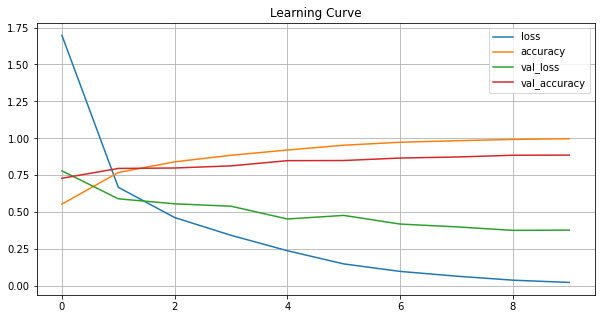

In [ ]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()

In [ ]:
def predictImages(data, class_names, model):
    
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
            
    plt.show()

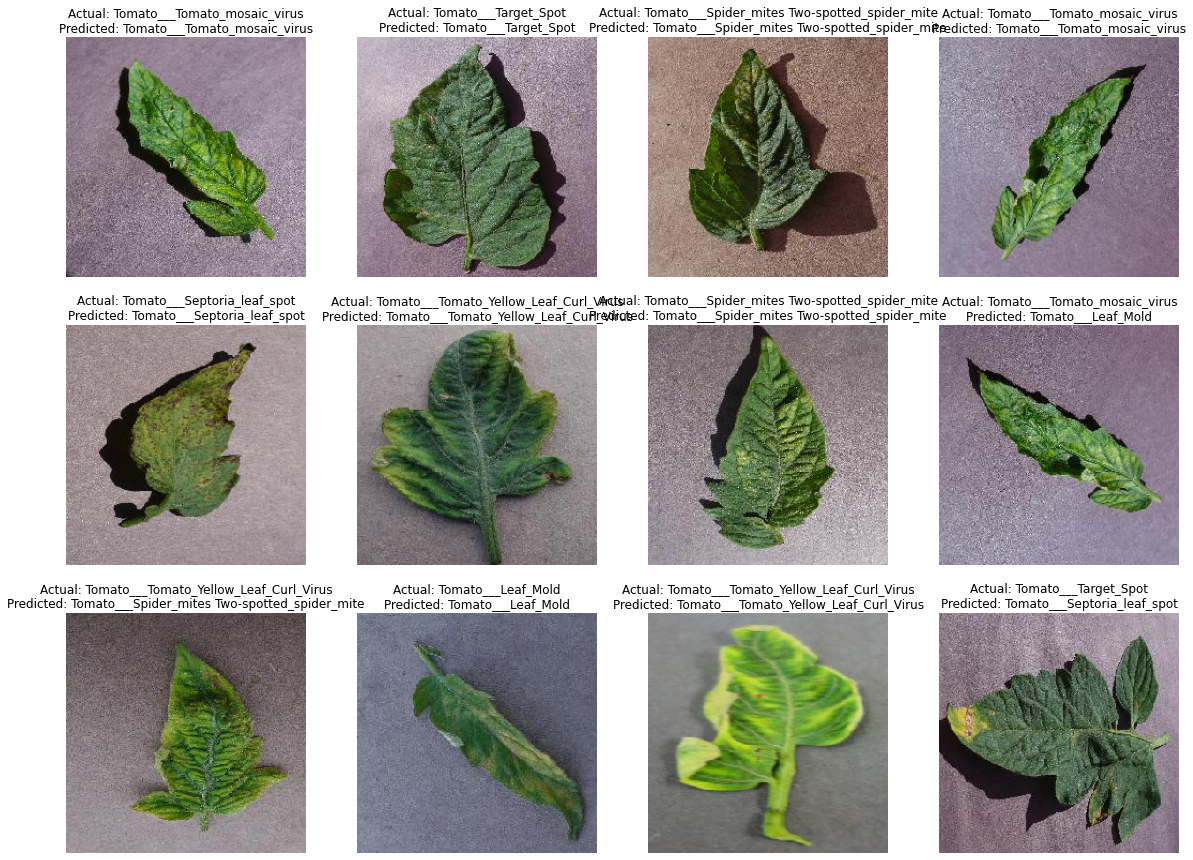

In [ ]:
predictImages(test_ds, class_names, model)